# Day 3 - Network basics

## Import libraries

In [111]:
import pandas as pd
import csv
import glob
import igraph as ig

## Import datasets

In [112]:
files = sorted(glob.glob('../data/raw/savedrecs_*.txt'))
publications_df = pd.concat(pd.read_csv(f, sep='\t', quoting=csv.QUOTE_NONE, 
                                        usecols=range(68), index_col='UT') for f in files)
publications_df = publications_df.sort_index()

In [113]:
publications_df.head()

,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,...,EY,PG,WC,SC,GA,PM,OA,HC,HP,DA
UT,,,,,,,,,,,,,,,,,,,,,
WOS:000084372900003,J,"Osaer, S; Goossens, B; Eysker, M; Geerts, S",NaN,NaN,NaN,"Osaer, S; Goossens, B; Eysker, M; Geerts, S",NaN,NaN,The effects of prophylactic anthelmintic treat...,ACTA TROPICA,...,NaN,12,Parasitology; Tropical Medicine,Parasitology; Tropical Medicine,267RJ,10643903.0,NaN,NaN,NaN,2019-04-02
WOS:000085634000001,J,"Aventin, L; Matthys, F",NaN,NaN,NaN,"Aventin, L; Matthys, F",NaN,NaN,Editorial: Do we negotiate human health ?,TROPICAL MEDICINE & INTERNATIONAL HEALTH,...,NaN,2,"Public, Environmental & Occupational Health; T...","Public, Environmental & Occupational Health; T...",289QT,10672198.0,NaN,NaN,NaN,2019-04-02
WOS:000085825800025,J,"Yersin, C; Bovet, P; Merien, F; Clement, J; La...",NaN,NaN,NaN,"Yersin, C; Bovet, P; Merien, F; Clement, J; La...",NaN,NaN,Pulmonary haemorrhage as a predominant cause o...,TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL ...,...,NaN,6,"Public, Environmental & Occupational Health; T...","Public, Environmental & Occupational Health; T...",292ZH,10748905.0,NaN,NaN,NaN,2019-04-02
WOS:000085825800030,J,"De Clercq, D; Vercruysse, J; Verle, P; Niasse,...",NaN,NaN,NaN,"De Clercq, D; Vercruysse, J; Verle, P; Niasse,...",NaN,NaN,Efficacy of artesunate against Schistosoma man...,TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL ...,...,NaN,2,"Public, Environmental & Occupational Health; T...","Public, Environmental & Occupational Health; T...",292ZH,10748910.0,NaN,NaN,NaN,2019-04-02
WOS:000086145500003,J,"Boelaert, JR; Taramelli, D",NaN,NaN,NaN,"Boelaert, JR; Taramelli, D",NaN,NaN,Untitled,AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYGIENE,...,NaN,2,"Public, Environmental & Occupational Health; T...","Public, Environmental & Occupational Health; T...",298NF,10761717.0,NaN,NaN,NaN,2019-04-02


You will see that the data has quite cryptic column headers. Each line contains information about a single publication, and contains various details, such as the title (`TI`), abstract (`AB`), authors (`AU`), journal title (`SO`) and cited references (`CR`). Unfortunately, the documentation of Web of Science is relatively limited, but some explanation can be found <a href="http://images.webofknowledge.com/WOKRS532FR6/help/WOS/hs_advanced_fieldtags.html">here</a>. You can retrieve this information in various ways from the pandas dataframe `publications_df`. For example, you can list the first five titles as follows:

## Data summarisation

The `pandas` package provides various ways to summarise the data and get a useful overview of the data. For example, you can group by a certain column, and count or sum things. For example, we can count the number of articles in each journal that is included in this dataset:

In [114]:
grouped_by_journal = publications_df.groupby('SO')
grouped_by_journal.size().sort_values(ascending=False)[:10]

SO
TROPICAL MEDICINE & INTERNATIONAL HEALTH                              1025
AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYGIENE                      360
PLOS NEGLECTED TROPICAL DISEASES                                       275
MALARIA JOURNAL                                                        197
TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL MEDICINE AND HYGIENE     133
PARASITES & VECTORS                                                    105
ACTA TROPICA                                                            82
JOURNAL OF TROPICAL PEDIATRICS                                          18
ANNALS OF TROPICAL MEDICINE AND PARASITOLOGY                            18
MEDECINE ET SANTE TROPICALES                                            18
dtype: int64

## Network generation

### Co-authorship

We first build a co-authorship network. We will do this one publication at the time. All combinations of authors that are involved in a publication are co-authors. Let us look at the authors for publication 0.

In [115]:
publications_df['AU'][0]

'Osaer, S; Goossens, B; Eysker, M; Geerts, S'

Note that the authors are all listed and separated with a semicolon (`;`). In computer terms, it is now a single *string*. We will split this string of all authors into a list of strings where each string then represents a single author.

In [116]:
publications_df['AU_split'] = publications_df['AU'].fillna('').str.split(';')

In [117]:
authors = publications_df['AU_split'][0]
authors

['Osaer, S', ' Goossens, B', ' Eysker, M', ' Geerts, S']

In [118]:
publications_df['AU_split'] = publications_df['AU'].fillna('').str.split(';').apply(lambda lst: [e.strip() for e in lst])
authors = publications_df['AU_split'][0]
authors

['Osaer, S', 'Goossens, B', 'Eysker, M', 'Geerts, S']

In order to create all possible combinations, we can use a convenient package, called `itertools`. The function `combinations` can generate all possible combinations of the elements of a list.

In [119]:
import itertools as itr
list(itr.combinations(authors, 2))

[('Osaer, S', 'Goossens, B'),
 ('Osaer, S', 'Eysker, M'),
 ('Osaer, S', 'Geerts, S'),
 ('Goossens, B', 'Eysker, M'),
 ('Goossens, B', 'Geerts, S'),
 ('Eysker, M', 'Geerts, S')]

Of course, we don't want to do this for a single publication only, but rather, for all publications in our dataset. We can do that using the function `apply`.

In [120]:
coauthors_per_publication = publications_df['AU_split'].apply(lambda authors: list(itr.combinations(authors, 2)))

The variable `coauthors_per_publication` is now a list of a list of co-authors per publication. That is, each element of `coauthors_per_publication` contains a list of all co-authors for that publication. So, `coauthors_per_publication[0]` contains the coauthors we examined previously.

In [121]:
coauthors_per_publication

UT
WOS:000084372900003    [(Osaer, S, Goossens, B), (Osaer, S, Eysker, M...
WOS:000085634000001                           [(Aventin, L, Matthys, F)]
WOS:000085825800025    [(Yersin, C, Bovet, P), (Yersin, C, Merien, F)...
WOS:000085825800030    [(De Clercq, D, Vercruysse, J), (De Clercq, D,...
WOS:000086145500003                       [(Boelaert, JR, Taramelli, D)]
                                             ...                        
WOS:000437429300018    [(Kaputu-Kalala-Malu, C, Kahamba, DM), (Kaputu...
WOS:000437432400002    [(Maotela, JK, Ramazani, SY), (Maotela, JK, Mi...
WOS:000437432400014    [(Kuwekita, M, Gosset, C), (Kuwekita, M, Guill...
WOS:000437437700018    [(Rakotonirina, EJ, Ravaoarisoa, L), (Rakotoni...
WOS:000437449800023    [(Traore, FA, Sako, FB), (Traore, FA, Sylla, D...
Name: AU_split, Length: 2338, dtype: object

In [122]:
coauthors_per_publication[0]

[('Osaer, S', 'Goossens, B'),
 ('Osaer, S', 'Eysker, M'),
 ('Osaer, S', 'Geerts, S'),
 ('Goossens, B', 'Eysker, M'),
 ('Goossens, B', 'Geerts, S'),
 ('Eysker, M', 'Geerts, S')]

Let us turn each element of this list into a separate row. This is done by using `explode` in `pandas`. Publications with only one author have no co-authors, which results in an `NA` (Not Available) value. We will drop those using `dropna`.

In [123]:
coauthors = coauthors_per_publication.explode().dropna()

Finally, we can create the actual network as follows

In [124]:
G_coauthorship = ig.Graph.TupleList(
      edges=coauthors.to_list(), # could use edges=coauthors.to_list()
      vertex_name_attr='author',
      directed=False
      )

Note that this graph will still contain many duplicate edges, because there are multiple edges present. Let us therefore simplify this graph, and simply count the number of multiple edges. We first create a so-called edge attribute `n_joint_papers`. We can create it by using the edge sequence `es` of the graph. We can then simply sum this weight when we simplify the graph.

In [125]:
G_coauthorship.es['n_joint_papers'] = 1
G_coauthorship = G_coauthorship.simplify(combine_edges='sum')

Let us see how many authors (i.e. nodes) there are in the network. This is called the `vcount` (vertex count) in `igraph`.

In [126]:
G_coauthorship.vcount()

8482

Similarly, the number of edges is available as the `ecount` of the graph.

In [127]:
G_coauthorship.ecount()

72938

We can do all sorts of analysis on this network. But first, we will create a bibliographic coupling network.

### Bibliographic coupling

Bibliographic coupling and co-authorship is in a sense very similar. Previously, we computed for each publication a combination of all co-authors. For bibliographic coupling we can compute for each cited reference the combinations of all citing journals. We will first create a dataframe of all journal citations (`SO`) of a certain cited reference (`CR`). Similar to the authors, we need to first split the cited references.

In [128]:
publication_with_cr_df = publications_df.loc[pd.notnull(publications_df['CR']), ['SO', 'CR']]
publication_with_cr_df['CR'] = publication_with_cr_df['CR'].str.split('; ')
publication_with_cr_df['CR']

UT
WOS:000084372900003    [Albers G. A. A., 1984, Immunogenetic approach...
WOS:000085634000001    [AVENTIN L, 1999, MILLENNIUM ROUND OMC, BENETT...
WOS:000085825800025    [ALLEN P, 1989, INTENS CARE MED, V15, P322, Bo...
WOS:000085825800030    [Picquet M, 1998, T ROY SOC TROP MED H, V92, P...
WOS:000086145500003    [BASILICO N, 1999, MOL PAR M WOODS HOL, P403, ...
                                             ...                        
WOS:000437429300018    [Bejon P, 2007, PLOS MED, V4, P1333, DOI 10.13...
WOS:000437432400002    [Agbovi KK, 2006, TRANSFUS CLIN BIOL, V13, P26...
WOS:000437432400014    [Audibert M, 2004, Med Trop (Mars), V64, P552,...
WOS:000437437700018    [Ai XQ, 2010, BMC PUBLIC HEALTH, V10, DOI 10.1...
WOS:000437449800023    [ANTONA D, 2006, B EPIDEMIOL HEBDO, V7, P53, M...
Name: CR, Length: 1452, dtype: object

In [129]:
publication_with_cr_df['CR'][0]

['Albers G. A. A., 1984, Immunogenetic approaches to the control of endoparasites with particular reference to parasites of sheep. Proceedings of a workshop held at Sydney University, October 22-23 1983, on behalf of the Australian Wool Corporation., P41',
 'Ankers P, 1998, PREV VET MED, V34, P215, DOI 10.1016/S0167-5877(97)00037-8',
 'Ankers P, 1994, Rev Elev Med Vet Pays Trop, V47, P201',
 'Barger I. A., 1982, Biology and control of endoparasites. McMaster Laboratory 50th Anniversary Symposium in Parasitology, University of Sydney, 5-6 November 1981., P133',
 'BARGER IA, 1998, VET PARASITOL, V72, P493',
 'BARGER IA, 1999, VET PARASITOL, V29, P41',
 'BULLERDIECK P, 1996, THESIS',
 'COBON DH, 1992, J AGR SCI, V118, P245, DOI 10.1017/S0021859600068854',
 '*DLS ITC, 1993, LIV CENS',
 'FRITSCHE T, 1993, VET PARASITOL, V49, P271, DOI 10.1016/0304-4017(93)90126-8',
 'GOOSSEN B, 1998, VET PARASITOL, V85, P25',
 'Goossens B, 1997, INT J PARASITOL, V27, P1579, DOI 10.1016/S0020-7519(97)00094-5

We now simply list all citations from a certain journal (`SO`) to a certain cited reference (`CR`).

In [130]:
journal_cits_df = publication_with_cr_df[['SO', 'CR']].explode('CR')
journal_cits_df

,SO,CR
UT,,
WOS:000084372900003,ACTA TROPICA,"Albers G. A. A., 1984, Immunogenetic approache..."
WOS:000084372900003,ACTA TROPICA,"Ankers P, 1998, PREV VET MED, V34, P215, DOI 1..."
WOS:000084372900003,ACTA TROPICA,"Ankers P, 1994, Rev Elev Med Vet Pays Trop, V4..."
WOS:000084372900003,ACTA TROPICA,"Barger I. A., 1982, Biology and control of end..."
WOS:000084372900003,ACTA TROPICA,"BARGER IA, 1998, VET PARASITOL, V72, P493"
...,...,...
WOS:000437449800023,MEDECINE ET SANTE TROPICALES,"Manga N M, 2009, Bull Soc Pathol Exot, V102, P221"
WOS:000437449800023,MEDECINE ET SANTE TROPICALES,Ministere de la Sante et de l'Hygiene publique...
WOS:000437449800023,MEDECINE ET SANTE TROPICALES,"Ndour CT, 2002, MED MALADIES INFECT, V32, P399..."


We then create all bibliographic couplings per cited reference as follows. We first group by the cited reference (`CR`) and then take all combinations of citing journals.

In [131]:
bibcoupling_per_cr = journal_cits_df.groupby('CR').apply(lambda x: list(itr.combinations(x['SO'], 2)))

We again `explode` all combinations of two sources citing the same reference.

In [132]:
bibcouplings = bibcoupling_per_cr.explode().dropna()
bibcouplings

CR
*BUR CENTR TRYP, 1995, GUID TECHN PROGR NAT                                    (TROPICAL MEDICINE & INTERNATIONAL HEALTH, TRO...
*BUR CENTR TRYP, 1995, GUID TECHN PROGR NAT                                    (TROPICAL MEDICINE & INTERNATIONAL HEALTH, PLO...
*BUR CENTR TRYP, 1995, GUID TECHN PROGR NAT                                    (TROPICAL MEDICINE & INTERNATIONAL HEALTH, PLO...
*BUR CENTR TRYP, 2002, DECL POL NAT LUTT CO                                    (TROPICAL MEDICINE & INTERNATIONAL HEALTH, TRO...
*CDCP, 1999, MMWR-MORBID MORTAL W, V48, P1                                     (AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYG...
                                                                                                     ...                        
von Seidlein L, 2000, LANCET, V355, P352, DOI 10.1016/S0140-6736(99)10237-X    (TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL...
von Seidlein L, 2000, LANCET, V355, P352, DOI 10.1016/S0140-6736(99)10237-X    (TRANSACTIONS O

We can then create the network.

In [133]:
G_coupling = ig.Graph.TupleList(
      edges=bibcouplings,
      vertex_name_attr='SO',
      directed=False
      )

<div class="alert alert-info">
    We again need to simplify this network. Create a new edge attribute called <code>coupling</code> set it to <code>1</code> and then sum this attribute when simplifying the network.
</div>

In [134]:
G_coupling.es['coupling'] = 1
G_coupling = G_coupling.simplify(combine_edges='sum')

This network should be reasonably sized, and you should be able to visualize this network by calling `ig.plot`.

<AxesSubplot:>

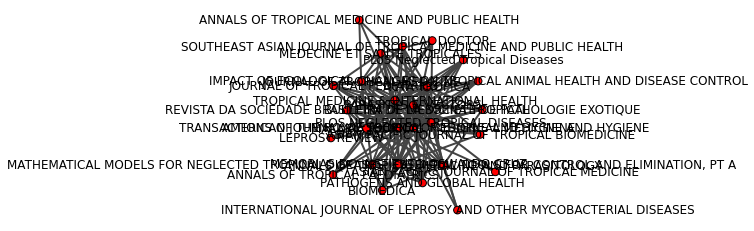

In [135]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ig.plot(G_coupling, vertex_label=G_coupling.vs['SO'], target=ax)

# Network analysis

Now that we have created some scientometric networks, let us look at some basic analyses of these networks.

## Connectivity

Let us start with a very simple question. Is the co-authorship network connected?

In [136]:
G_coauthorship.is_connected()

False

Apparently, not all authors in this dataset are connected via co-authored papers.

<div class="alert alert-info">
How many authors do you think will be connected to each other? 500? 5000? Almost everybody?
</div>

In order to take a closer look, we need to detect the *connected components*. This is easily done, but the function is confusingly called `clusters`.

In [137]:
components = G_coauthorship.connected_components()

In [138]:
components

Let us only look at the giant component.

In [139]:
H = components.giant()

Let us check how many nodes are in the giant component. We can call the function `summary`.

In [140]:
H.summary()

'IGRAPH U--- 7871 69928 -- \n+ attr: author (v), n_joint_papers (e)'

The first line indicates that we have an undirected graph (`U`) with 7871 nodes and 69928 links. The next line shows vertex attributes (indicated by the `v` behind the name of the attribute), and edge attributes (indicated by the `e`).

<div class="alert alert-info">
    <ol>
      <li> What is the percentage of nodes that are in the giant component? 
      <li> Double check whether the giant component is connected.
    </ol>
</div>

In [141]:
H.vcount() / G_coauthorship.vcount() * 100

92.79651025701486

Let us take a closer look at how far authors in this data set are apart from one another. Let us simply take a look at node number `0` (remember, the first node has number `0`, not `1`) and node number `355`. 

In [142]:
paths = G_coauthorship.get_shortest_paths(0, 355)
paths

[[0, 3, 223, 355]]

This returns a list of all shortests paths of the nodes between node number 0 and node number 355. In fact, there is only one path, so let us select that.

In [143]:
path = paths[0]
path

[0, 3, 223, 355]

<div class="alert alert-info">
How many nodes are in the path? What is the path length?
</div>

These numbers probably do not mean that much to you. You can find out more about an individual node by looking at the `VertexSequence` of `igraph`, abbreviated as `vs`. This is a sort of list of all vertices, and is indexed by brackets `[ ]`, similar to lists, instead of parentheses `( )` as we do for functions.

In [144]:
G_coauthorship.vs[0]

igraph.Vertex(<igraph.Graph object at 0x124329140>, 0, {'author': 'Osaer, S'})

The vertex itself is also a type of list (called a *dictionary*), and you can only return the author name as follows

In [145]:
G_coauthorship.vs[0]['author']

'Osaer, S'

You can also list multiple vertices at once.

In [146]:
G_coauthorship.vs[[0, 3, 223, 355]]['author']

['Osaer, S', 'Geerts, S', 'Van Marck, E', 'Watkins, W']

You can of course also simply pass the variable `path` that we constructed earlier.

In [147]:
G_coauthorship.vs[path]['author']

['Osaer, S', 'Geerts, S', 'Van Marck, E', 'Watkins, W']

This shows that Osaer collaborated with Geert, who collaborated with Van Mark, who in the end collaborated with Watkins.

You can also get the vertex by searching for the author name. For example, if we want to find `'Van Marck, E'` we can use the following.

In [148]:
G_coauthorship.vs.find(author_eq = 'Van Marck, E')

igraph.Vertex(<igraph.Graph object at 0x124329140>, 223, {'author': 'Van Marck, E'})

Here `author_eq` refers to the condition that the vertex attribute `author` should **eq**ual `'Van Marck, E'`.

<div class="alert alert-info">
    Find the shortest path from <code>'Van Marck, E'</code> to <code>'Migchelsen, S'</code>. Who is in between?
</div>

In [149]:
G_coauthorship.vs.find(author_eq = 'Migchelsen, S')

igraph.Vertex(<igraph.Graph object at 0x124329140>, 3556, {'author': 'Migchelsen, S'})

In [150]:
paths = G_coauthorship.get_shortest_paths(223, 3556)
path = paths[0]
G_coauthorship.vs[path]['author']

['Van Marck, E', "D'Alessandro, U", 'Schallig, H', 'Migchelsen, S']

We can let `igraph` also calculate how far apart all nodes are.

<div class="alert alert-warning">
The following may take some time to run
</div>

In [151]:
path_lengths = G_coauthorship.path_length_hist()
print(path_lengths)

N = 30976412, mean +- sd: 3.9397 +- 0.9969
Each * represents 225559 items
[ 1,  2):  (72938)
[ 2,  3): ****** (1478785)
[ 3,  4): ************************************** (8781467)
[ 4,  5): ********************************************************* (12856894)
[ 5,  6): ************************* (5864521)
[ 6,  7): ******* (1579011)
[ 7,  8): * (305739)
[ 8,  9):  (35034)
[ 9, 10):  (1967)
[10, 11):  (56)


<div class="alert alert-info">
How far apart are most authors? Do you think most authors are close by? Or do you think they are far apart?
</div>

Let us take a closer look at the path between node 0 and node 355 again. Instead of the nodes on the path, we now want to take a closer look at the edges on the path.

In [152]:
epath = G_coauthorship.get_shortest_paths(0, 355, output='epath')
epath

[[2, 9, 6192]]

There are three edges on this path, but the numbers themselves are not very informative. They refer to the edges, and similar to the `VertexSequence` we encountered earlier, there is also an `EdgeSequence`, abbreviated as `es`. Let us take a closer look to the number of joint papers that the authors had co-authored.

In [153]:
G_coauthorship.es[epath[0]]['n_joint_papers']

[1.0, 2.0, 3.0]

Perhaps there are other paths that connect the two authors with more joint papers? Perhaps we could use the number of joint papers as weights?

In [154]:
epath = G_coauthorship.get_shortest_paths(0, 355, weights='n_joint_papers', output='epath')
epath

[[2, 71, 5163, 4827, 8584]]

We do get a different path, which it is actually longer. Let us take a look at the number of joint papers.

In [155]:
G_coauthorship.es[epath[0]]['n_joint_papers']

[1.0, 1.0, 1.0, 1.0, 1.0]

The total number of joint papers is lower! That is because *shortest path* means: the path with the lowest sum of the weights. This is clearly not what we want. You should always be aware of this whenever using the concept of the *shortest path*.

<div class="alert alert-danger">
<b>Attention!</b> Weighted shortest paths have the <em>lowest</em> total weight.
</div>

## Clustering coefficient

Let us look whether co-authors of an author also tend to be co-authors among themselves.

Let us take a look at the co-authors of of author number 0, which are called the *neighbors* in network terminology.

In [156]:
G_coauthorship.neighborhood(0)

[0, 1, 2, 3]

What we actually want to know is whether many of those neighors are connected. That is, we want to take the subgraph of all authors that have co-authored with author number 0.

In [157]:
H = G_coauthorship.induced_subgraph(G_coauthorship.neighborhood(0))
H.summary()

'IGRAPH U--- 4 6 -- \n+ attr: author (v), n_joint_papers (e)'

This subgraph only has 4 nodes (including node 0, so it has 3 neighbours) and 6 edges. This is sufficiently small to be easily plotted for visual inspection.

<AxesSubplot:>

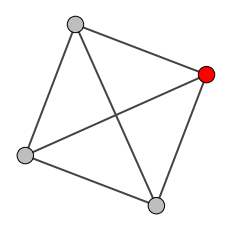

In [158]:
H.vs['color'] = 'grey'
H.vs[0]['color'] = 'red'
fig, ax = plt.subplots()
ig.plot(H, target=ax)

<div class="alert alert-info">
Do many of the co-authors collaborate among themselves as well? Why do you think this happens?
</div>

We can also ask `igraph` to calculate the clustering coefficient (which is called *transitivity* in igraph, which is the same concept using different terms) of node 0.

In [159]:
G_coauthorship.transitivity_local_undirected(0)

1.0

<div class="alert alert-info">
What percentage of the co-authors of node 0 have also written papers with each other?
</div>

You can calculate the average for all nodes using the function `transitivity_avglocal_undirected`.

<div class="alert alert-info">
What percentage of the co-authors have also written papers with each other on average? Do you think this is high or not?
</div>

## Centrality

Often, people want to identify which nodes seem to be most important in some way in the network. This is often thought of as a type of *centrality* of a node.

### Degree

The simplest type of centrality is the *degree* of a node, which is simply the number of its neighbors. Previously, we saw that node 0 had 3 neighbors, we therefore say its degree is 3.

In [182]:
G_coauthorship.degree(0)

3

We can also simply calculate the degree for everybody and store it in a new vertex attribute called `degree`.

In [183]:
G_coauthorship.vs['degree'] = G_coauthorship.degree()

<div class="alert alert-info">
    What is the degree of <code>'Van Marck, E'</code>?
</div>

We can also take a look at the complete degree distribution. To plot it, we load the `matplotlib` package. We import the plotting functionality and name the package `plt`. We also include a statement telling Python to show the plots immediately in this notebook.

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

Now let us plot a histogram of the degree, using 50 bins.

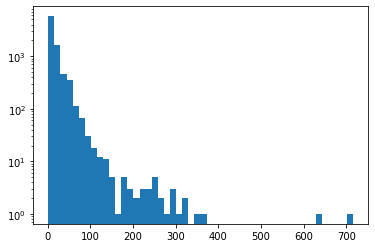

In [185]:
plt.hist(G_coauthorship.vs['degree'], 50);
plt.yscale('log')

This clearly shows that the degree distribution is quite skewed. Most authors have only few collaborators, while a few authors have many collaborators. If the degree distribution is so skewed, it is sometimes referred to as a *scale-free* network, although the exact definition has been a topic of intense discussion recently.

The code below sorts the nodes in descending order of the degree.

In [186]:
highest_degree = sorted(G_coauthorship.vs, key=lambda v: v['degree'], reverse=True)

The `sorted` function takes a list as input, `G_coauthorship.vs` in our case, and sorts it according to a sort key. We indicate the sort key by a small function, called a `lambda` function, that returns the degree. In other words, the `sorted` function will sort the nodes according to the degree. By indicating `reverse=True` we obtain a list that is sorted highest to lowest, instead of the other way around.

You can look at the first five results in the following way.

In [190]:
highest_degree[:5]

[igraph.Vertex(<igraph.Graph object at 0x1228aa740>, 139, {'author': "D'Alessandro, U", 'degree': 715}),
 igraph.Vertex(<igraph.Graph object at 0x1228aa740>, 42, {'author': 'Boelaert, M', 'degree': 641}),
 igraph.Vertex(<igraph.Graph object at 0x1228aa740>, 341, {'author': 'Dorny, P', 'degree': 369}),
 igraph.Vertex(<igraph.Graph object at 0x1228aa740>, 63, {'author': 'Buscher, P', 'degree': 348}),
 igraph.Vertex(<igraph.Graph object at 0x1228aa740>, 64, {'author': 'Dujardin, JC', 'degree': 326})]

So, apparently, U D'Allessandro has collaborated with 715 other authors! This of course only considers the number of co-authors, it does not take into account the number of papers written with somebody else.
When specifying such *edge weights* like the number of joint papers, the weighted degree is referred to as the *strength* of a node (which is sometimes a bit confusing term). 

Let us look at the strength of node 0.

In [191]:
G_coauthorship.strength(0, weights='n_joint_papers')

3.0

Apparently, author 0 collaborated with 3 different authors, and has a total strength of 3. But what does this 3 mean? We need to carefully think about this. Suppose that author 0 has co-authored a single publication with three other co-authors, then each of the three co-authors would have an edge weight of `n_joint_papers = 1`. So, the strenght would be 3. Hence, the strength denotes the total number of collaborations that an author had, which depends both on the number of publications and the number of collaborators per paper.

Sometimes, we wish to take into account the number of co-authorships when creating a link weight. We can then fractionally count the weight of each collaboration between $n_a$ authors as

$$\frac{1}{n_a - 1}.$$

We need to go back to the `publications_df` in order to construct such a *fractional* edge weight.

In [192]:
import itertools as itr
[(coauthor[0], coauthor[1], 1/(len(authors) - 1)) for coauthor in itr.combinations(authors, 2)]

[('Osaer, S', 'Goossens, B', 0.3333333333333333),
 ('Osaer, S', 'Eysker, M', 0.3333333333333333),
 ('Osaer, S', 'Geerts, S', 0.3333333333333333),
 ('Goossens, B', 'Eysker, M', 0.3333333333333333),
 ('Goossens, B', 'Geerts, S', 0.3333333333333333),
 ('Eysker, M', 'Geerts, S', 0.3333333333333333)]

We again do this for all publications.

In [193]:
coauthors_per_publication = publications_df['AU_split'].apply(
    lambda authors: 
        [(coauthor[0], coauthor[1], 1, 1/(len(authors) - 1)) 
             for coauthor in itr.combinations(authors, 2)])

The variable `coauthors_per_publication` is now a list of a list of co-authors per publication, but including a full weight of `1` and a fractional weight of `1/(len(authors) - 1)`, where `len(authors)` is the number of authors of the publications. We again `explode` this list.

In [194]:
coauthors = coauthors_per_publication.explode().dropna()

We can again create the network, but now we can pass two edge attributes, `n_joint_papers` and `n_joint_papers_frac`. We of course also have to simplify the network again.

In [197]:
G_coauthorship = ig.Graph.TupleList(
      edges=coauthors.to_list(),
      vertex_name_attr='author',
      directed=False,
      edge_attrs=('n_joint_papers', 'n_joint_papers_frac')
      )
G_coauthorship = G_coauthorship.simplify(loops=False, combine_edges='sum')

<div class="alert alert-info">
What is the sum of <code>n_joint_papers_frac</code> over all co-authors? Then shouldn't the strength sum up to a whole number? Why isn't that the case here? (Hint: look at the authors of publication <code>'WOS:000242241600004'</code)
</div>

In [201]:
publications_df.loc['WOS:000242241600004', 'AU']

'Schenkel, K; Rijal, S; Koirala, S; Koirala, S; Vanlerberghe, V; Van der Stuyft, P; Gramiccia, M; Boelaert, M'

In [202]:
publications_df.loc['WOS:000242241600004', 'TI']

'Visceral leishmaniasis in southeastern Nepal: A cross-sectional survey on Leishmania donovani infection and its risk factors'

### Betweenness centrality

Betweenness centrality is much more elaborate, and gives an indication of the number of times a node is on the shortest path from one node to another node.

As you can imagine, this can take quite some time to calculate for all nodes. We will therefore use the somewhat smaller bibliographic coupling network of journals.

<div class="alert alert-warning">
    <b>Note:</b> On larger networks, it may take a long time to calculate the betweenness centrality.
</div>

In [203]:
G_coupling.vs['betweenness'] = G_coupling.betweenness()

Now we can look at the journals that have the highest betweenness.

In [204]:
sorted(G_coupling.vs, key=lambda v: v['betweenness'], reverse=True)[:5]

[igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 1, {'SO': 'PLOS NEGLECTED TROPICAL DISEASES', 'betweenness': 43.42301587301588, 'betweenness_weighted': 51.4095238095238, 'pagerank': 0.07814324326935798, 'pagerank_weighted': 0.21483806133497008}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 0, {'SO': 'TROPICAL MEDICINE & INTERNATIONAL HEALTH', 'betweenness': 38.92301587301587, 'betweenness_weighted': 0.5833333333333333, 'pagerank': 0.07696548264630954, 'pagerank_weighted': 0.1820837844437379}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 4, {'SO': 'TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 37.08968253968254, 'betweenness_weighted': 81.24523809523811, 'pagerank': 0.07698657058058592, 'pagerank_weighted': 0.09323447958945565}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 2, {'SO': 'AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 29.81468253968254, 'betweenness_weighted': 0.2, 'pagerank': 0.0713214

As we did previously when dealing with shortest paths, we can also use a weight for determining the shortest paths.

In [205]:
G_coupling.vs['betweenness_weighted'] = G_coupling.betweenness(weights='coupling')

<div class="alert alert-info">
What is journal with the highest weighted betweenness centrality? Does this make sense if you compare it to the unweighted betweenness centrality?
</div>

<div class="alert alert-danger">
    <b>Attention!</b> Weighted shortest paths have the <em>lowest</em> total weight.
</div>

### Pagerank

One way of identifying central nodes relies on the idea of a random walk in a network. We will study this in the journal bibliographic coupling network. When performing such a random walk, we simply go from one journal to the next, following the bibliographic coupling links. The journal that is most frequently visited during such a random walk is then seen as most central. This is actually the idea that underlies Google's famous search engine. Luckily, we can compute that a lot faster than betweenness.

In [206]:
G_coupling.vs['pagerank'] = G_coupling.pagerank()

<div class="alert alert-info">
Get the top 5 most central journals according to Pagerank. Who is the most central? Are the results very different from the betweenness?
</div>

In [207]:
sorted(G_coupling.vs, key=lambda v: v['pagerank'], reverse=True)[:5]

[igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 1, {'SO': 'PLOS NEGLECTED TROPICAL DISEASES', 'betweenness': 43.42301587301588, 'betweenness_weighted': 51.4095238095238, 'pagerank': 0.07814324326935798, 'pagerank_weighted': 0.21483806133497008}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 4, {'SO': 'TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 37.08968253968254, 'betweenness_weighted': 81.24523809523811, 'pagerank': 0.07698657058058592, 'pagerank_weighted': 0.09323447958945565}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 0, {'SO': 'TROPICAL MEDICINE & INTERNATIONAL HEALTH', 'betweenness': 38.92301587301587, 'betweenness_weighted': 0.5833333333333333, 'pagerank': 0.07696548264630954, 'pagerank_weighted': 0.1820837844437379}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 2, {'SO': 'AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 29.81468253968254, 'betweenness_weighted': 0.2, 'pagerank': 0.0713214

We can again take into account the weights. In pagerank this means that a journal that is a more closely bibliographically coupled will be more likely to be visited during a random walk. This is actually much more in line with our intuition than the shortest path. Let us see what we get if we do that.

In [176]:
G_coupling.vs['pagerank_weighted'] = G_coupling.pagerank(weights='coupling')

<div class="alert alert-info">
Are the results different for the weighted version of pagerank?
</div>

In [208]:
sorted(G_coupling.vs, key=lambda v: v['pagerank_weighted'], reverse=True)[:5]

[igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 1, {'SO': 'PLOS NEGLECTED TROPICAL DISEASES', 'betweenness': 43.42301587301588, 'betweenness_weighted': 51.4095238095238, 'pagerank': 0.07814324326935798, 'pagerank_weighted': 0.21483806133497008}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 0, {'SO': 'TROPICAL MEDICINE & INTERNATIONAL HEALTH', 'betweenness': 38.92301587301587, 'betweenness_weighted': 0.5833333333333333, 'pagerank': 0.07696548264630954, 'pagerank_weighted': 0.1820837844437379}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 2, {'SO': 'AMERICAN JOURNAL OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 29.81468253968254, 'betweenness_weighted': 0.2, 'pagerank': 0.07132148276054204, 'pagerank_weighted': 0.12657074002880048}),
 igraph.Vertex(<igraph.Graph object at 0x1228aab40>, 4, {'SO': 'TRANSACTIONS OF THE ROYAL SOCIETY OF TROPICAL MEDICINE AND HYGIENE', 'betweenness': 37.08968253968254, 'betweenness_weighted': 81.24523809523811, 'pagerank': 0.0769865

<div class="alert alert-info">
Pagerank is very similar to the techniques that underly the journal "Eigenfactor" and the "SCImago Journal Rank", which are seen as indicators of the scientific impact of a journal. Do you think it makes sense to interpret Pagerank on a bibliographic coupling network as the scientific impact of a journal? Why (not)?
</div>

## Co-authorship using bipartite projection (optional)

We can also create co-authorship using a more theoretical approach from graph theory. We can first construct a network consisting of publications and authors.

We first again `explode` all authors for each publication, and create a graph out of it.

In [214]:
author_pubs_df = publications_df['AU_split'].explode()
author_pubs_df

UT
WOS:000084372900003        Osaer, S
WOS:000084372900003     Goossens, B
WOS:000084372900003       Eysker, M
WOS:000084372900003       Geerts, S
WOS:000085634000001      Aventin, L
                           ...     
WOS:000437449800023       Traore, M
WOS:000437449800023       Kpamy, DO
WOS:000437449800023    Doumbouya, M
WOS:000437449800023       Sylla, AO
WOS:000437449800023     Diallo, MOS
Name: AU_split, Length: 18704, dtype: object

In [ ]:

G_pub_authors = ig.Graph.TupleList(
      edges=author_pubs_df.reset_index().values,
      vertex_name_attr='name',
      directed=False
      )

This network consists of two types: publications and authors. This is called a *bipartite* graph. We can automatically get the types using `is_bipartite`.

In [213]:
is_bipartite, types = G_pub_authors.is_bipartite(return_types = True)
is_bipartite

True

The actual types are simply returned as a list of `True` and `False` values, which are arbitrary labels for publications and authors. Let us see what the first label stands for.

In [221]:
types[0]

True

In [222]:
G_pub_authors.vs[0]

igraph.Vertex(<igraph.Graph object at 0x12294c440>, 0, {'name': 'WOS:000084372900003'})

From the `name` of node `0` we can see that it refers to a publication, and so `False` indicates publications, while `True` indicates authors.

We now would like to perform a so-called *bipartite projection* onto the authors. This is exactly the type of operation that leads to a co-authorship network. If we were to *project* onto the publication, we would end up with a network of publications where each pair of publications is linked if it is authored by the same author.

In [223]:
G_author_projection = G_pub_authors.bipartite_projection(types=types, which=True)

By default, it keeps track of the *multiplicity* (i.e. the number of joint papers) in the `weight` edge attribute. Unfortunately, it is not possible to do fractional counting using this approach.

<div class="alert alert-info">
    Check the number of nodes in the bipartite projection. Why is it different from the number of nodes in the earlier constructed <code>G_coauthorship</code>? (Hint: checkout the degree.)
</div>

8482

# Analysis of your own data

You have now learned the basics of handling WoS files and transforming them into scientometric networks. Please take some time now to do your own analysis.

<div class="alert alert-info">
Go to <a href="http://webofknowledge.com/">Web of Science</a> and select a publication set of interest. Make sure that the number of publications is higher than 1000, but lower than 5000. Export the files as follows:
<ol>
  <li> Export using "Save to Other File Formats".
  <li> Select the appropriate records (e.g. 1-500, 501-1000, etc...).
  <li> Select the Record Content "Full Record and Cited References".
  <li> Select the File Format "Tab delimited (Win, UTF8)".
  <li> Click on Send.
</ol>
Repeat the above steps for each batch of 500 publications.

Load the data from all files you downloaded using <code>pandas</code>
</div>

<div class="alert alert-info">
Create a co-authorship network of your publications. Hint: use the approach you encountered earlier.
</div>

<div class="alert alert-info">
Identify the authors that are most central to the coauthorship network and interpret the results.
</div>

<div class="alert alert-info">
Create a co-citation network of your publications. Hint: use the bibliographic coupling approach, but switch the roles of the source and the target.
</div>

<div class="alert alert-info">
Identify the publications that are most central to the co-citation network and interpret the results. Are they relatively recent publications or not?
</div>